In [14]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer

import utils
np.random.seed(9112001)
np.set_printoptions(precision=5)

In [15]:
# consider 3 qubits
N   = 3

""" Build A matrix such that the Hamiltoninan has
    entries with both real and imaginary part 
    inside (-bound, bound)
"""
bound = 1
H = utils.get_random_H(N, bound)

evs, w = eigh(H)
w      = w.T
gs     = w[0] / np.linalg.norm(w[0]) # we need to normalize it because later we calculate eps
w_max  = w[np.argmax(np.abs(evs))] # select eigenvector that corresponds to the eigenvalue of maximum module

evect_idx = 7
w1     = w[evect_idx] / np.linalg.norm(w[evect_idx])

v_min = np.min(np.abs(evs))
v_max = np.max(np.abs(evs))
print(f"Smallest eigenvalue: {evs[0]:.5f}")
print(f"Biggest eigenvalue: {evs[-1]:.5f}")
print(f"Smallest eigenvalue in magnitude v_min (index = {np.argmin(np.abs(evs))}): {v_min:.5f}")
print(f"Biggest eigenvalue in magnitude v_max (index = {np.argmax(np.abs(evs))}): {v_max:.5f}")
print(f"gs is w_max: {np.allclose(gs, w_max)}")
print(f"Eval associated to evect with index = {evect_idx} (w1): {evs[evect_idx]:.5f}")
print(f"w1 is w_max: {np.allclose(w1, w_max)}")

Smallest eigenvalue: -2.54006
Biggest eigenvalue: 2.29397
Smallest eigenvalue in magnitude v_min (index = 4): 0.11862
Biggest eigenvalue in magnitude v_max (index = 0): 2.54006
gs is w_max: True
Eval associated to evect with index = 7 (w1): 2.29397
w1 is w_max: False


In [16]:
M_max    = 4
M_values = np.arange(1, M_max + 1)
n_points = 6
a_values = np.linspace(0, 1, n_points)

data = []

for M in tqdm(M_values):
    t = M / (2 * v_max) # moving along the straight line in the heatmap
    
    for a_0 in a_values:
        n_anc = 2 * M
        psi_0 = a_0 * gs + np.sqrt(1 - a_0 ** 2) * w1
        psi_0 /= np.linalg.norm(psi_0)

        # print(f"Success between psi0 and w[1]: {np.abs(np.vdot(w[1], psi_0)) ** 2}")

        qc = utils.get_itimevol_circuit(N, M, H, t, psi_0)
        qc.save_statevector()

        aer_sim = Aer.get_backend("aer_simulator_statevector")
        qc_tp   = transpile(qc, backend=aer_sim)
        result  = aer_sim.run(qc_tp, shots=1).result()

        final_state_dict     = result.get_statevector(qc_tp).to_dict()
        final_state_sys_dict = {}

        for k, v in final_state_dict.items():
            if k[-n_anc:] == '0' * n_anc:
                k_new = k[:N]
                final_state_sys_dict[k_new] = v

        final_state_sys_list = [(k, v) for k, v in final_state_sys_dict.items()]
        final_state_sys_list = sorted(final_state_sys_list)
        final_state          = np.array([t[1] for t in final_state_sys_list])
        final_state          /= np.linalg.norm(final_state)

        eps = 1 - np.abs(np.vdot(gs, final_state)) ** 2
        data.append((M, a_0, eps))

100%|██████████| 4/4 [00:51<00:00, 12.89s/it]


    M  a_0           eps
0   1  0.0  1.000000e+00
1   1  0.2  8.047716e-01
2   1  0.4  4.741637e-01
3   1  0.6  2.339211e-01
4   1  0.8  8.810228e-02
5   1  1.0 -4.440892e-16
6   2  0.0  1.000000e+00
7   2  0.2  4.145283e-01
8   2  0.4  1.341094e-01
9   2  0.6  4.983271e-02
10  2  0.8  1.632345e-02
11  2  1.0  0.000000e+00
12  3  0.0  1.000000e+00
13  3  0.2  1.084239e-01
14  3  0.4  2.591270e-02
15  3  0.6  8.927673e-03
16  3  0.8  2.842117e-03
17  3  1.0 -4.440892e-16
18  4  0.0  1.000000e+00
19  4  0.2  2.046008e-02
20  4  0.4  4.548345e-03
21  4  0.6  1.544827e-03
22  4  0.8  4.893098e-04
23  4  1.0  0.000000e+00


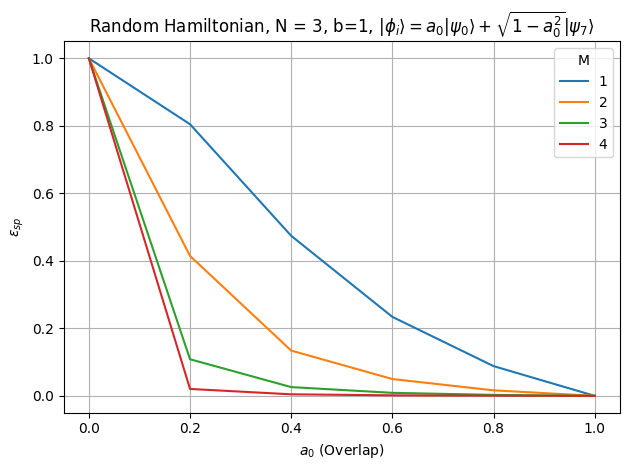

In [17]:
df = pd.DataFrame(data, columns=["M", "a_0", "eps"])
print(df)
sns.lineplot(df, x = "a_0", y = "eps", hue = "M", palette="tab10")
plt.xlabel(r'$a_0$ (Overlap)')
plt.ylabel(r'$\epsilon_{sp}$')
plt.title(rf"Random Hamiltonian, N = {N}, b={bound}, $|\phi_i\rangle = a_0|\psi_0\rangle + \sqrt{{1 - a_0^2}}|\psi_{evect_idx}\rangle$")
plt.tight_layout()
plt.grid()